In [1]:
__imp

Libraries have been loaded


### Load Additional Libraries

In [2]:
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, KFold

basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

# contains feature pertaining to raw application file
train = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')
test  = pd.read_pickle('../data/interim/feature_groups/application_test.pkl')

CPU times: user 31.5 ms, sys: 56.7 ms, total: 88.1 ms
Wall time: 87.7 ms


In [3]:
%%time

data = pd.read_hdf('../data/interim/dataset1/data.h5', key='data')

CPU times: user 4.76 s, sys: 1.01 s, total: 5.77 s
Wall time: 5.82 s


## Adversarial Validation

In [8]:
%%time

data       = pd.concat((train, test))
data.index = np.arange(len(data))

CPU times: user 107 ms, sys: 32 ms, total: 139 ms
Wall time: 139 ms


In [9]:
for c in data.select_dtypes(include=['category']).columns:
    data[c] = data[c].cat.codes

In [4]:
data['is_test'] = 1
data['is_test'].iloc[:307511] = 0

In [5]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [7]:
params = {
    'objective': 'binary',
    'max_depth': 4,
    'metric': 'auc',
    'nthread': 4,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.94716	eval's auc: 0.946534
[40]	train's auc: 0.95495	eval's auc: 0.953928
[60]	train's auc: 0.960335	eval's auc: 0.959067
[80]	train's auc: 0.964323	eval's auc: 0.962768
[100]	train's auc: 0.967128	eval's auc: 0.965407
[120]	train's auc: 0.96924	eval's auc: 0.967311
[140]	train's auc: 0.970881	eval's auc: 0.96863
[160]	train's auc: 0.972636	eval's auc: 0.970105
[180]	train's auc: 0.973816	eval's auc: 0.971045
[200]	train's auc: 0.975076	eval's auc: 0.971971
[220]	train's auc: 0.976259	eval's auc: 0.972878
[240]	train's auc: 0.97707	eval's auc: 0.9734
[260]	train's auc: 0.97792	eval's auc: 0.974041
[280]	train's auc: 0.978522	eval's auc: 0.974401
[300]	train's auc: 0.979237	eval's auc: 0.974864
[320]	train's auc: 0.98006	eval's auc: 0.975476
[340]	train's auc: 0.980629	eval's auc: 0.975759
[360]	train's auc: 0.981118	eval's auc: 0.97597
[380]	train's auc: 0.981729	eval's auc: 0.976396
[400]	train's auc: 0

In [8]:
m.save_model('../data/processed/models/adversarial_model.txt')

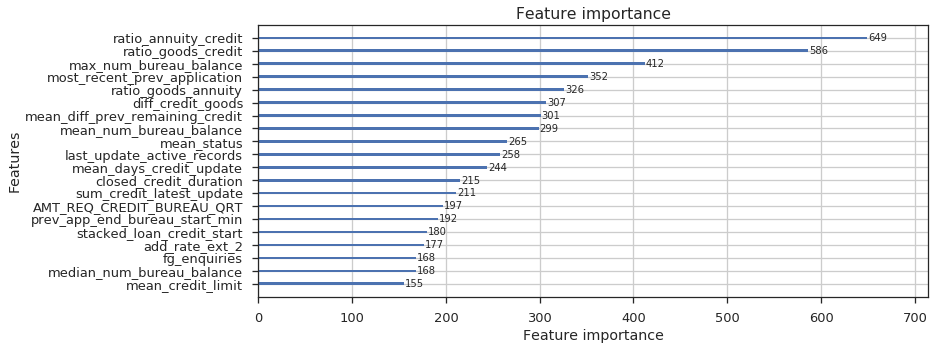

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='split', max_num_features=20, ax=ax);

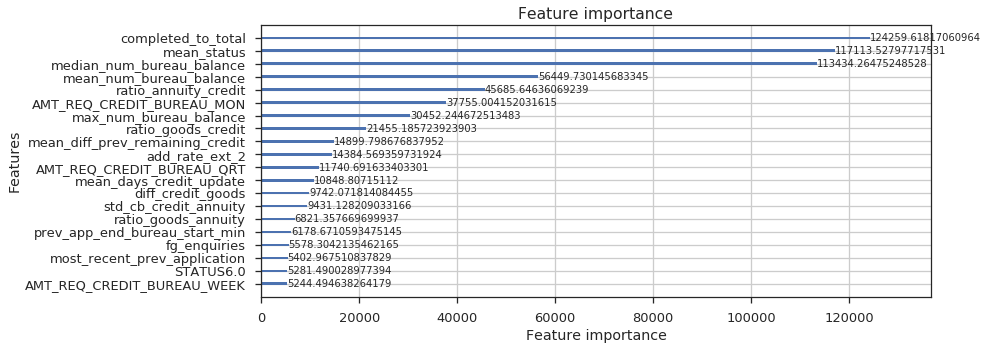

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='gain', max_num_features=20, ax=ax);

### OOF prediction for training set

In [4]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

data['is_test'] = 1
data['is_test'].iloc[:307511] = 0

data  = data.sample(frac=1.) # shuffle rows
df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [5]:
%%time

estimator  = lgb.LGBMClassifier(n_estimators=2015, max_depth=4, objective='binary')
oof_scores = cross_val_predict(estimator, df, y, cv=5, method='predict_proba')

CPU times: user 2h 35min 49s, sys: 26.8 s, total: 2h 36min 15s
Wall time: 42min 55s


In [6]:
np.save('../data/processed/models/oof_scores.npy', oof_scores)

In [ ]:
oof_scores = np.load('../data/processed/models/oof_scores.npy')

In [8]:
df_copy                        = df.copy()
df_copy.loc[:, 'is_test_prob'] = oof_scores[:, 1]
df_copy.loc[:, 'is_test']      = y
df_copy.loc[:, 'SK_ID_CURR']   = data.SK_ID_CURR

target                         = data.TARGET.iloc[:307511]

In [9]:
del data
gc.collect()

41

In [10]:
df_copy[df_copy.is_test == 0].sort_values(by='is_test_prob', ascending=False)\
                             .loc[:, ['SK_ID_CURR', 'is_test_prob']]

,SK_ID_CURR,is_test_prob
122198,241677,9.977956e-01
169662,296636,9.948267e-01
165807,292206,9.941103e-01
22096,125733,9.936265e-01
226966,362902,9.930864e-01
128724,249306,9.930038e-01
166744,293302,9.928986e-01
4052,104738,9.914845e-01
84549,198087,9.913126e-01
117614,236383,9.898453e-01


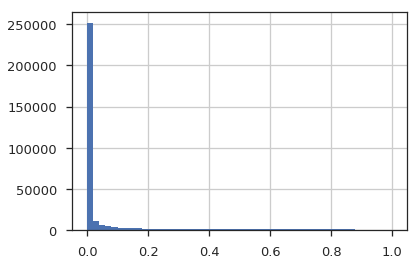

In [12]:
df_copy[df_copy.is_test == 0].is_test_prob.hist(bins=50);

In [77]:
def fold_gen(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .15)]

    for fold in range(5):
        test_index  = list(x.sample(frac=48744).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        yield train_index,  test_index

In [22]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .3)].shape[0]

16668

In [23]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob <= 0.3)].shape[0]

290843

In [24]:
16668 / 307511

0.05420293908185398

In [26]:
.2 * 48744

9748.800000000001

In [33]:
def save_folds(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .3)]
    test_folds = []
    
    for fold in range(6):
        test_index  = list(x.sample(n=9748).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        test_folds.append(test_index)
    
    test_folds = np.array(test_folds).T
    cv_df      = pd.DataFrame(test_folds, columns=[f'F{i}' for i in range(6)])
    
    cv_df.to_csv('../data/raw/cv_adversarial_idx_v1.csv', index=False)
#     return cv_df

In [34]:
save_folds(df_copy)

In [29]:
cv_folds = save_folds(df_copy)

In [30]:
len((set(cv_folds['F0'].values) & set(cv_folds['F2'].values))) / len(cv_folds['F0'])

0.5812474353713583

In [31]:
len((set(cv_folds['F0'].values) & set(cv_folds['F3'].values))) / len(cv_folds['F0'])

0.5853508411981945

In [32]:
len((set(cv_folds['F0'].values) & set(cv_folds['F4'].values))) / len(cv_folds['F0'])

0.5860689372178909

In [84]:
df_copy.shape

(356255, 123)

In [82]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED
}

num_boost_round       = 500
early_stopping_rounds = 100

ltrain = lgb.Dataset(df.iloc[:len(train)].copy(), TARGET, feature_name=df.columns.tolist())

lgb.cv(params, 
       ltrain, 
       num_boost_round, 
       folds=fold_gen(df_copy), 
       early_stopping_rounds=early_stopping_rounds, 
       verbose_eval=20)

[20]	cv_agg's auc: 0.618144 + 0.00514626
[40]	cv_agg's auc: 0.631824 + 0.0046029
[60]	cv_agg's auc: 0.63968 + 0.00515748
[80]	cv_agg's auc: 0.64062 + 0.00485862
[100]	cv_agg's auc: 0.642104 + 0.00573209
[120]	cv_agg's auc: 0.642286 + 0.00572781
[140]	cv_agg's auc: 0.642618 + 0.00600976
[160]	cv_agg's auc: 0.642657 + 0.00613822
[180]	cv_agg's auc: 0.642169 + 0.0060855
[200]	cv_agg's auc: 0.64151 + 0.00599734
[220]	cv_agg's auc: 0.641801 + 0.0057658
[240]	cv_agg's auc: 0.642513 + 0.00623979
[260]	cv_agg's auc: 0.64221 + 0.00644424


{'auc-mean': [0.6042937582096902,
  0.6063851080102118,
  0.6094948735497355,
  0.6105071593059883,
  0.6103113565861819,
  0.609949146327001,
  0.6112450210864804,
  0.611922664355651,
  0.6130385780092173,
  0.6135514649349239,
  0.6140567851372335,
  0.6138722483547333,
  0.6138905358882123,
  0.6144706221804735,
  0.6154927026924676,
  0.6163287187043333,
  0.616554768416919,
  0.6173352621591126,
  0.6174060247445852,
  0.6181444201569033,
  0.6187143963227383,
  0.6194944579588235,
  0.6198957050849789,
  0.6207915448273522,
  0.6219778419869648,
  0.6230271612099727,
  0.6237795045767934,
  0.6248345699284803,
  0.6255729154444939,
  0.626186580135842,
  0.6268817748326054,
  0.6272010226809934,
  0.6273822084294582,
  0.6275895204726845,
  0.6282070344389259,
  0.6287205101248088,
  0.6293304442291344,
  0.6304520246260321,
  0.6314348211934767,
  0.63182393503278,
  0.6320910920507157,
  0.6328286905792679,
  0.6332499251145899,
  0.6335400030841262,
  0.6339219347473423,
  0.